In [1]:
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

from operator import itemgetter
from ast import literal_eval

import matplotlib.pyplot as plt
import powerlaw as pl
import seaborn as sns
import random

from wordcloud import WordCloud

import plotly.express as px
import plotly.graph_objects as go
from plotly.graph_objects import Layout
from plotly.subplots import make_subplots

import nltk
nltk.download('stopwords')
nltk.download('punkt')

import string
from nltk.stem import SnowballStemmer

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# load preprocessed data
path = "E:\\PycharmProject\\ada_project\\data\\"
data = pd.read_csv(path + 'processed-quotes-2019.csv')
data.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,domains,nationality,gender,party,id
0,2019-04-08-048753,It is immoral. It is harmful. It is hurtful.,Donald Trump,Q22686,2019-04-08 16:22:00,44,"['mercedsunstar', 'sacbee', 'mynorthwest', 'la...",United States of America,male,Republican Party,Q22686
1,2019-05-15-053302,It is important for our equine science student...,Sally Johnson,Q42336656,2019-05-15 18:03:22,1,['lanereport'],United States of America,female,NaN,Q42336656
2,2019-02-27-055406,It is important to many Native American tribes...,Rafael Ortega,Q16672061,2019-02-27 00:00:00,1,['kstp'],Mexico,male,NaN,Q16672061
3,2019-12-08-023053,"It is impossible, biologically, truly to `rest...",Barry Lopez,Q809063,2019-12-08 06:00:00,1,['timescolonist'],United States of America,male,NaN,Q809063
4,2019-02-21-000088,Chilton put it on a little tape recorder and...,Sam the Sham,Q1971786,2019-02-21 11:05:34,1,['nashvillescene'],United States of America,male,NaN,Q1971786


# 1. Analysis for heavy-tailed distributions
In the first step, we try to analyze the heavy-tailed distributions in the Quotebanks. To be specific,we visualize the distribution of speakers **occurrence**, **nationality**, **gender**, and **party**. Besides, we also draw the distribution of domains in URLs to study popularity of different medias.

In [3]:
def plot_power_law(freq_data, title=None):
    # detect whether the distribution is heavy-tailed
    freq_data = freq_data.values.squeeze()
    np.seterr(divide='ignore', invalid='ignore')
    sns.set(style="ticks", font_scale=1.2)
    fig, ax = plt.subplots() 
    plt.grid()
    pl.plot_pdf(freq_data, ax=ax, linewidth=2)

    ax.set_xlim(ax.get_xlim())
    fit = pl.Fit(freq_data, discrete=True)
    fit.power_law.plot_pdf(ax=ax, linestyle='--', color=(118 / 255, 204 / 255, 95 / 255))

    ax.set_xlabel('# of occurance')
    ax.set_ylabel('Probability')
    ax.set(title=title)

    plt.draw()
    plt.show()

  0%|          | 0/14183294 [00:00<?, ?it/s]

Calculating best minimal value for power law fit


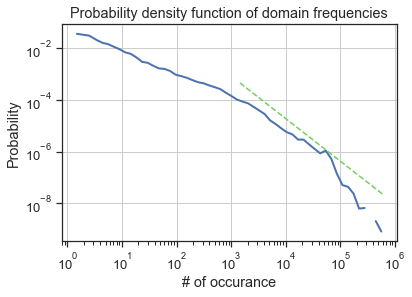

msn                629604
gamereactor        409900
einnews            407224
breitbart          310886
businessinsider    276334
nbcsports          265399
indiatimes         248296
washingtontimes    225449
pulse              210432
espn               204211
sfgate             191762
krmg               190096
seattletimes       189677
stuff              188377
wokv               186479
newsok             180949
news965            160529
smh                158311
nytimes            158230
foxnews            153853
wsbradio           148716
eurosport          147230
brisbanetimes      144860
nzherald           144508
newkerala          137549
go                 133331
castanet           131581
news18             131135
breakingnews       124767
nzcity             123846
dtype: int64

In [4]:
# transfer domains from str tolist
data['domains'] = data['domains'].apply(literal_eval)

# combine all domains into a single list
domain_counter = []
for domain in tqdm(data['domains']):
    domain_counter += domain
# calculate the frequencies of each domain
domain_counter = pd.Series(domain_counter)
domain_freq = domain_counter.value_counts()
plot_power_law(domain_freq, title='Probability density function of domain frequencies')

domain_freq[:30]

Calculating best minimal value for power law fit


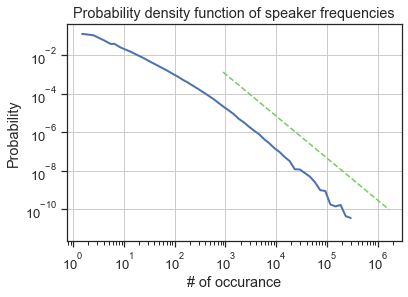

,numOccurrences
speaker,
Donald Trump,1649686
Boris Johnson,291742
Sam Bishop,214796
Nancy Pelosi,204779
Joe Biden,190692
Jeremy Corbyn,186809
Narendra Modi,153489
Mike Pompeo,146920
Elizabeth Warren,108792


In [5]:
speaker_data = data.groupby('speaker')
speaker_freq = speaker_data.agg({'numOccurrences': 'sum'}).sort_values(by='numOccurrences', 
                                                                                 ascending=False)
plot_power_law(speaker_freq, title='Probability density function of speaker frequencies')
speaker_freq[:20]

Calculating best minimal value for power law fit


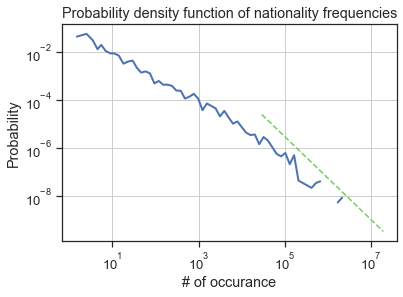

,numOccurrences
nationality,
United States of America,19487828
United Kingdom,7352827
Australia,2253338
Canada,2016677
India,1781554
Germany,667442
Ireland,622427
New Zealand,620021
France,572258


In [6]:
nationality_data = data.groupby('nationality')
nationality_freq = nationality_data.agg({'numOccurrences': 'sum'}).sort_values(by='numOccurrences', 
                                                                                 ascending=False)
plot_power_law(nationality_freq, title='Probability density function of nationality frequencies')
nationality_freq[:20]

Calculating best minimal value for power law fit


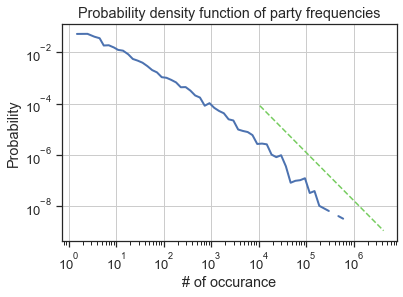

,numOccurrences
party,
Republican Party,4279589
Democratic Party,3620122
Conservative Party,1332539
Labour Party,635143
Bharatiya Janata Party,435745
Indian National Congress,267192
Liberal Party of Canada,211723
Scottish National Party,200697
Australian Labor Party,158458


In [7]:
party_data = data.groupby('party')
party_freq = party_data.agg({'numOccurrences': 'sum'}).sort_values(by='numOccurrences', 
                                                                                 ascending=False)
plot_power_law(party_freq, title='Probability density function of party frequencies')
party_freq[:20]

In [8]:
gender_data = data.groupby('gender')
gender_freq = gender_data.agg({'numOccurrences': 'sum'}).sort_values(by='numOccurrences', 
                                                                                 ascending=False)
gender_freq

,numOccurrences
gender,
male,38426442
female,8991933
transgender female,28082
genderfluid,23390
non-binary,19810
cisgender female,9914
transgender male,4652
cisgender male,1513
genderqueer,772


As we can see, distribution of speakers occurance, nationality, gender, and party are all heavy-tailed. 
This reflects the wide variety of data imbalances in the dataset.

# 2. Visualize the domain quotation bias
In this section, we select four famous news publisher:**New York Times**,**CNN**, **Foxnews** ,and **News Max**, to study their perference on speakers. We choose the top ten most quoted speakers for each domain. Furthermore, we also studied differences of speakers attributes when quoting, and different domains interest on different news topics.

,nationality,gender,party,domain_counts
speaker,,,,
Donald Trump,United States of America,male,Republican Party,6944
Elizabeth Warren,United States of America,female,Democratic Party,1058
Joe Biden,United States of America,male,Democratic Party,1036
Nancy Pelosi,United States of America,female,Democratic Party,854
Bernie Sanders,United States of America,male,Liberty Union Party,750
Pete Buttigieg,United States of America,male,Democratic Party,696
Mike Pompeo,United States of America,male,Republican Party,574
Bill de Blasio,United States of America,male,Democratic Party,410
Cory Booker,United States of America,male,Democratic Party,409


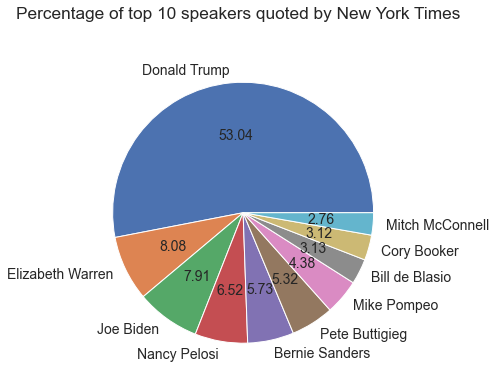

In [9]:
def select_domain_topk_freq_speaker(data, domain, topk=None):
    # this function is used to extract the topk most quoted speakers for a giving news domain
    data['domain_counts'] = data['domains'].apply(lambda x: x.count(domain))
    domain_data = data[data['domain_counts'] > 0]
    speaker_domain_data = domain_data.groupby('speaker')
    speaker_freq = speaker_domain_data.agg({'domain_counts': 'sum'}).sort_values(by='domain_counts', 
                                                                                 ascending=False)
    data.drop(['domain_counts'], axis=1, inplace=True)
    if topk is not None:
        return speaker_freq[:topk]
    else:
        return speaker_freq

def search_speaker_info(data, speakers):
    # extract the speakers info.
    tmp = data.drop_duplicates('speaker')
    tmp = tmp.set_index('speaker')
    tmp = tmp.loc[speakers.index]
    tmp = pd.concat([tmp, speakers], axis=1)
    return tmp[['nationality', 'gender', 'party', 'domain_counts']]

nytimes_top_speakers = select_domain_topk_freq_speaker(data, 'nytimes', topk=10)
nytimes_top_speakers.plot.pie(subplots=True, figsize=(6, 6), autopct='%.2f', legend=False, ylabel='',
                             fontsize=14, title='Percentage of top 10 speakers quoted by New York Times')
search_speaker_info(data, nytimes_top_speakers)

,nationality,gender,party,domain_counts
speaker,,,,
Donald Trump,United States of America,male,Republican Party,9178
Joe Biden,United States of America,male,Democratic Party,1855
Elizabeth Warren,United States of America,female,Democratic Party,1349
Pete Buttigieg,United States of America,male,Democratic Party,1337
Nancy Pelosi,United States of America,female,Democratic Party,1314
Bernie Sanders,United States of America,male,Liberty Union Party,1063
Mike Pompeo,United States of America,male,Republican Party,974
Kamala Harris,United States of America,female,Democratic Party,757
William Barr,NaN,male,NaN,689


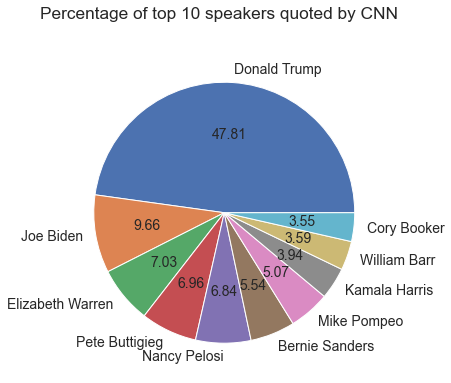

In [10]:
cnn_top_speakers = select_domain_topk_freq_speaker(data, 'cnn', topk=10)
cnn_top_speakers.plot.pie(subplots=True, figsize=(6, 6), autopct='%.2f', legend=False, ylabel='',
                             fontsize=14, title='Percentage of top 10 speakers quoted by CNN')
search_speaker_info(data, cnn_top_speakers)

,nationality,gender,party,domain_counts
speaker,,,,
Donald Trump,United States of America,male,Republican Party,9367
Joe Biden,United States of America,male,Democratic Party,2245
Nancy Pelosi,United States of America,female,Democratic Party,1810
Alexandria Ocasio-Cortez,United States of America,female,Democratic Party,1548
Bernie Sanders,United States of America,male,Liberty Union Party,1477
Elizabeth Warren,United States of America,female,Democratic Party,1109
Pete Buttigieg,United States of America,male,Democratic Party,893
Lindsey Graham,United States of America,male,Republican Party,841
William Barr,NaN,male,NaN,835


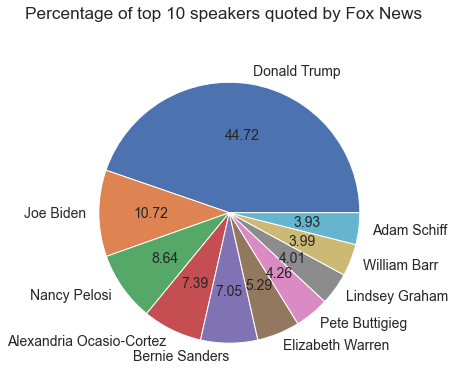

In [11]:
foxnews_top_speakers = select_domain_topk_freq_speaker(data, 'foxnews', topk=10)
foxnews_top_speakers.plot.pie(subplots=True, figsize=(6, 6), autopct='%.2f', legend=False, ylabel='',
                             fontsize=14, title='Percentage of top 10 speakers quoted by Fox News')
search_speaker_info(data, foxnews_top_speakers)

,nationality,gender,party,domain_counts
speaker,,,,
Donald Trump,United States of America,male,Republican Party,6282
Mike Pompeo,United States of America,male,Republican Party,764
Nancy Pelosi,United States of America,female,Democratic Party,761
Joe Biden,United States of America,male,Democratic Party,702
Lindsey Graham,United States of America,male,Republican Party,617
Larry Kudlow,United States of America,male,Republican Party,602
Bernie Sanders,United States of America,male,Liberty Union Party,537
Newt Gingrich,United States of America,male,Republican Party,522
Alan Dershowitz,United States of America,male,Democratic Party,503


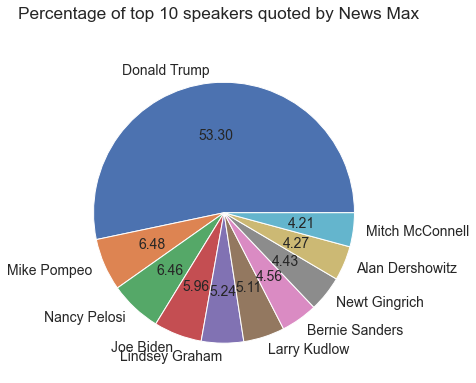

In [12]:
newsmax_top_speakers = select_domain_topk_freq_speaker(data, 'newsmax', topk=10)
newsmax_top_speakers.plot.pie(subplots=True, figsize=(6, 6), autopct='%.2f', legend=False, ylabel='',
                             fontsize=14, title='Percentage of top 10 speakers quoted by News Max')
search_speaker_info(data, newsmax_top_speakers)

Donald Trump dominates the top ten most quoted speakers (around half of the top 10 quotations). Besides, around 4/5 of speakers are male, which reflects the gender inequality lies in media: males' sound is much louder than females. Moreover, the bias also lies in speakers' parties: the DNC speakers have much more likely to be explored by readers than GOP (except Trump).

In [13]:
# In this part, we try to compare the difference of preference quotation people between these four publishers.

# we union the top 10 most quoted people for four domain, 
# and visualize the heatmap to display the discrepancy amount them.
indices = set(nytimes_top_speakers.index) | set(cnn_top_speakers.index) | set(foxnews_top_speakers.index) | set(newsmax_top_speakers.index)
nytimes_speakers = select_domain_topk_freq_speaker(data, 'nytimes').loc[indices]
cnn_speakers = select_domain_topk_freq_speaker(data, 'cnn').loc[indices]
foxnews_speakers = select_domain_topk_freq_speaker(data, 'foxnews').loc[indices]
newsmax_speakers = select_domain_topk_freq_speaker(data, 'newsmax').loc[indices]
heatmap_data = pd.concat([nytimes_speakers, cnn_speakers, foxnews_speakers, newsmax_speakers], axis=1)
heatmap_data.columns = ['nytimes', 'cnn', 'foxnews', 'newsmax']
heatmap_data

,nytimes,cnn,foxnews,newsmax
speaker,,,,
William Barr,279,689,835,297
Elizabeth Warren,1058,1349,1109,492
Adam Schiff,267,656,823,452
Mike Pompeo,574,974,638,764
Larry Kudlow,107,153,97,602
Joe Biden,1036,1855,2245,702
Cory Booker,409,682,650,225
Mitch McConnell,361,654,598,496
Newt Gingrich,38,4,240,522


<AxesSubplot:ylabel='speaker'>

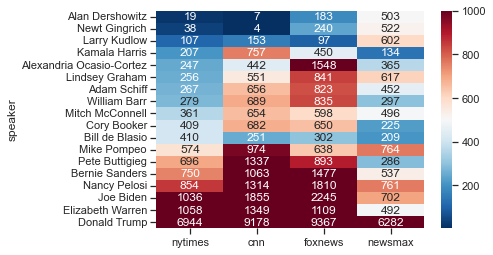

In [14]:
# we do not do the normalization because we wang to compare the raw values of quotation occurrence among them
sns.set(style="ticks", font_scale=1)
heatmap_data.sort_values(by='nytimes', inplace=True)
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="RdBu_r", vmax=1000)

From the heatmap we can observe that:
+ 1.In general, for the most famous people(e.g, Trump, Warren, and Biden), media's preference are largely concore with each other.
+ 2.But for those less popular people, media many have different interest in citing their sentences.

Now we try to do some basic analysis on news outlets' interest on speakers' profiles, including gender, nationality, and party.

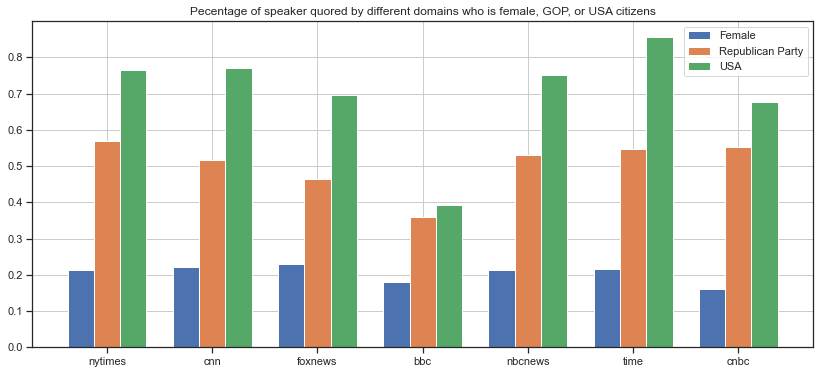

In [15]:
domains_set = ['nytimes', 'cnn', 'foxnews', 'bbc', 'nbcnews', 'time', 'cnbc']
gender_percentage = []
party_percentage = []
nationality_percentage = []

for domain in domains_set:
    domain_data = data[data['domains'].apply(lambda x: domain in x)]

    domain_gender_data = domain_data.groupby('gender')
    domain_gender_freq = domain_gender_data.agg({'numOccurrences': 'sum'}).sort_values(by='numOccurrences',
                                                                                       ascending=False)

    gender_per = domain_gender_freq.loc['female'] / domain_gender_freq[:2].sum()
    gender_percentage.append(gender_per[0])

    domain_party_data = domain_data.groupby('party')
    domain_party_freq = domain_party_data.agg({'numOccurrences': 'sum'}).sort_values(by='numOccurrences',
                                                                                     ascending=False)

    party_per = domain_party_freq.loc['Republican Party'] / domain_party_freq.sum()
    party_percentage.append(party_per[0])

    domain_nationality_data = domain_data.groupby('nationality')
    domain_nationality_freq = domain_nationality_data.agg({'numOccurrences': 'sum'}).sort_values(by='numOccurrences',
                                                                                                 ascending=False)
    nationality_per = domain_nationality_freq.loc['United States of America'] / domain_nationality_freq.sum()
    nationality_percentage.append(nationality_per[0])
plt.figure(figsize=(14, 6))
x=np.arange(len(domains_set))
bar_width=0.25

plt.bar(x, gender_percentage, bar_width, label='Female')
plt.bar(x+bar_width, party_percentage, bar_width, label='Republican Party')
plt.bar(x+bar_width*2, nationality_percentage, bar_width, label='USA')

plt.title('Pecentage of speaker quored by different domains who is female, GOP, or USA citizens')
plt.grid(linestyle='-')
plt.legend()
plt.xticks(x+bar_width, domains_set)
plt.show()

form the plot we can conclude that:
+ Female are less representative in news quotations: only 20% of occurrences quotations are spoken by women.
+ Republican Party contribute half of the speakers' party. Based on the previous analysis, we believe it is caused by Trump's high quotation occurrence in medias.
+ Since the majority of the selected news outlets are from the United States, it is not surprising that American speakers make up approximately 80 percent of the audience.

Now, we try to probe into the media's interest on different topics, to be specific, we use the TF-IDF method to transfer the original quotation into vector, then we use the cosine similarity to extract the related quotations for a specific query. We can use the package in sklearn which can help us finish the TF-IDF task efficiently.

In [16]:
# all quotation sentences.
original_documents = data['quotation'].values
# Retrieval model
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df=1, stop_words='english')
features = tf.fit_transform(original_documents)

# Return all document ids that that have cosine similarity with the query larger than a threshold
def search_vec_sklearn(query, features, threshold=0.1):
    new_features = tf.transform([query])
    cosine_similarities = linear_kernel(new_features, features).flatten()
    related_docs_indices, cos_sim_sorted = zip(*sorted(enumerate(cosine_similarities), key=itemgetter(1),
                                                       reverse=True))
    doc_ids = []
    for i, cos_sim in enumerate(cos_sim_sorted):
        if cos_sim < threshold:
            break
        doc_ids.append(related_docs_indices[i])
    return doc_ids

  0%|          | 0/4 [00:00<?, ?it/s]

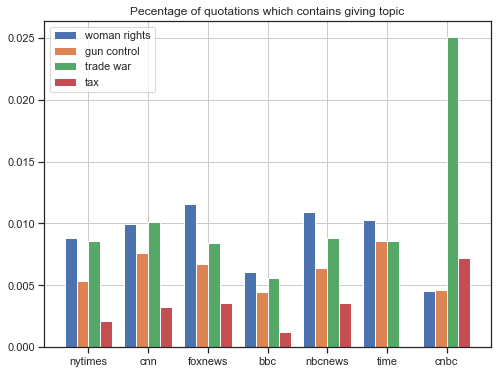

In [17]:
topics = ['woman rights', 'gun control', 'trade war', 'tax']
all_percents = []
for topic in tqdm(topics):
    ret_ids = search_vec_sklearn(topic, features)
    topic_data = data.iloc[ret_ids]
    percents = []
    for domain in domains_set:
        domain_data = data[data['domains'].apply(lambda x: domain in x)]
        topic_domain_data = topic_data[topic_data['domains'].apply(lambda x: domain in x)]
        percents.append(len(topic_domain_data) / len(domain_data))
    all_percents.append(percents)

x=np.arange(len(domains_set))
bar_width=0.2
plt.figure(figsize=(8, 6))
for i, percents in enumerate(all_percents):
    plt.bar(x+bar_width*i, percents, bar_width, label=topics[i])

plt.title('Pecentage of quotations which contains giving topic')
plt.grid(linestyle='-')
plt.legend()
plt.xticks(x+bar_width*1.5, domains_set)
plt.show()

We can easily see that the interest varies widely between different media.

# 3. An in-depth analysis of the gender bias in the Quotebank and the impact of the speaker's party affiliation and nationality.
Gender bias in the news media has gotten a lot of attention lately, and the variations in news coverage caused by gender have been studied from a variety of angles. However, quoting, which is common in all forms of news coverage, has received insufficient attention. Quoted material in the news helps us to look at gender bias in the news from a new perspective because quotes are straightforward, direct, and accurate expressions of the speaker's point of view.


## 3.1 Overview of gender inequality

We first take a general overview of gender inequality in Quotebank.

In [18]:
# load the preprocessed gender bias statics data
data_folder = 'E:\JupyterNotebook\Ada\Project\m3\\all_gender_freq.csv'
all_gender_freq = pd.read_csv(data_folder)
all_gender_freq

,gender,speaker,quote,count
0,male,1771658.0,61509042.0,228674655.0
1,female,526565.0,12704175.0,48346221.0
2,others,3277.0,144659.0,577029.0


In [31]:
colors = ["#cedef0", "#9d9ad9"]

layout = Layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)

fig = make_subplots(rows=1, cols=3, specs=[[{"type": "pie"}, {"type": "pie"}, {"type": "pie"}]],
                    subplot_titles=["Speaker", "Quotation",
                                    "Occurrence"])

fig.add_trace(
    go.Pie(labels=all_gender_freq['gender'], values=all_gender_freq['speaker'], name='Speaker'),
    row=1, col=1  # 1*2
)

fig.add_trace(
    go.Pie(labels=all_gender_freq['gender'], values=all_gender_freq['quote'], name='Quotation'),
    row=1, col=2  # 2*1
)
fig.add_trace(
    go.Pie(labels=all_gender_freq['gender'], values=all_gender_freq['count'], name='Occurrence'),
    row=1, col=3  # 2*2
)

fig.update_traces(textposition='inside', textinfo='percent+label', insidetextorientation='horizontal',
                  hoverinfo="label+percent+name",
                  hole=.3, textfont_size=20, hoverlabel=dict(
        bgcolor="#424c50",
        font_size=16,
        font_family="lora"
    ),
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.update_layout(uniformtext_minsize=15,  # 文本信息的最小值
                  uniformtext_mode='hide',
                  paper_bgcolor='#383B55',
                  plot_bgcolor='rgba(0,0,0,0)',
                  margin=dict(t=20, l=10, r=10, b=10)  # 小于最小值则被隐藏
                  )
fig.layout.font.family = 'lora'
fig.layout.font.color = '#FFFFFF'

fig.show()

From January 1, 2015, through April 30, 2020, we show three types of gender percentages (The number of different speakers in the dataset is referred to as **Speaker**. The number of different quotations is represented by the term **Quotation**. And The total number of quotations that appear in the media is referred to as the **Occurrence**).

 At the first glance, you can easily observe that over **80%** of speakers quoted by outlets are men, which is consistent with other related work on gender bias. Interestingly, the percentage of women speakers is about 5% higher than the other two types of aggregations, which means that though women accounted for nearly a quarter of the entire speakers, they were still less quoted by news outlets. The under-representation of women in society in general and in news articles reflect that we are far from gender equality.



## 3.2 Females percentages in quotation: for different nationality, news outlets, and parties.
In this section, we select several representative news outlets, parties, and nationalities to analyze their gender ratios in order to find plausible explanations for the gender bias in the news.

We select the following seven famous medias:
+ New York Times
+ CNN
+ Fox News
+ BBC
+ NBC News
+ Time
+ CNBC

nytimes
cnn
foxnews
bbc
nbcnews
time
cnbc


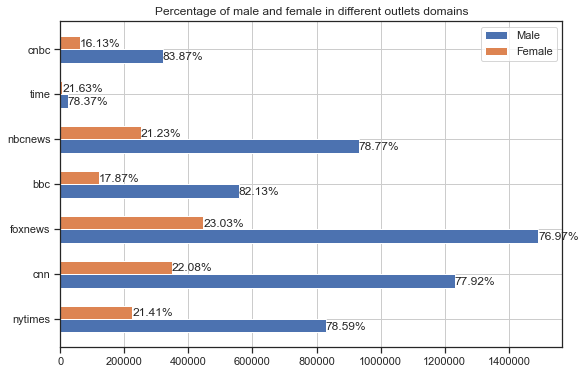

In [20]:
# News outlets
domains_set = ['nytimes', 'cnn', 'foxnews', 'bbc', 'nbcnews', 'time', 'cnbc']
male_count = []
female_count = []
gender_percentage = []

for domain in domains_set:
    print(domain)
    domain_data = data[data['domains'].apply(lambda x: domain in x)]

    domain_gender_data = domain_data.groupby('gender')
    domain_gender_freq = domain_gender_data.agg({'numOccurrences': 'sum'}).sort_values(by='numOccurrences',
                                                                                       ascending=False)
    male_count.append(domain_gender_freq.loc['male'][0])
    female_count.append(domain_gender_freq.loc['female'][0])

    gender_per = domain_gender_freq.loc['female'] / domain_gender_freq[:2].sum()
    gender_percentage.append(gender_per[0])


fig, ax = plt.subplots(figsize=(9, 6))
ax.get_xaxis().get_major_formatter().set_scientific(False)
y=np.arange(len(domains_set))
bar_width=0.3

plt.barh(y, male_count, bar_width, label='Male')

plt.barh(y+bar_width, female_count, bar_width, label='Female')

for a, b1, b2, v in zip(y, male_count, female_count, gender_percentage):
    plt.text(b1, a-0.3*bar_width, '{:.2%}'.format(1-v))
    plt.text(b2, a+0.7*bar_width, '{:.2%}'.format(v)) # , ha='center', va='bottom')

plt.title('Percentage of male and female in different outlets domains')
plt.grid(linestyle='-')
plt.legend()
plt.yticks(y+0.5*bar_width, domains_set)
plt.show()

From the figure we can see that, female speakers are always in the disadvantaged position (whatever the news outlet is) so that the percentage variances among news outlets are not significantly different (highly consistent trends). This phenomenon inspires us that media preferences themselves may have little impact on the production of gender bias.

We select the following seven most common parties occur in Quotebank:
+ Republican Party
+ Democratic Party
+ Conservative Party
+ Labour Party
+ Liberal Democrats
+ Bharatiya Janata Party
+ Indian National Congress

Republican Party
Democratic Party
Conservative Party
Labour Party
Liberal Democrats
Bharatiya Janata Party
Indian National Congress


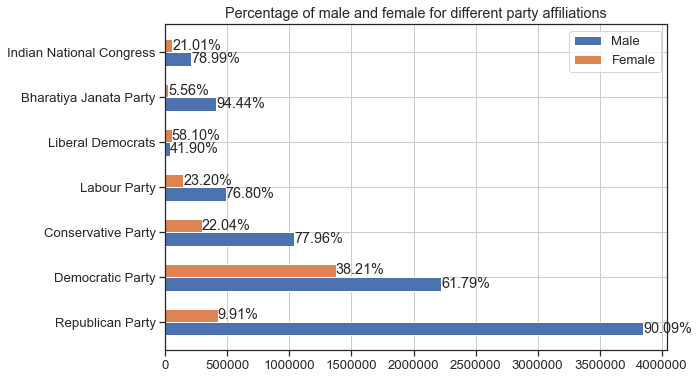

In [21]:
# Speaker's political party
party_set = ['Republican Party', 'Democratic Party', 'Conservative Party',
               'Labour Party', 'Liberal Democrats', 'Bharatiya Janata Party', 'Indian National Congress']
male_count = []
female_count = []
gender_percentage = []

for domain in party_set:
    print(domain)
    domain_data = data[data['party'].apply(lambda x: domain == x)]

    domain_gender_data = domain_data.groupby('gender')
    domain_gender_freq = domain_gender_data.agg({'numOccurrences': 'sum'}).sort_values(by='numOccurrences',
                                                                                       ascending=False)
    male_count.append(domain_gender_freq.loc['male'][0])
    female_count.append(domain_gender_freq.loc['female'][0])

    gender_per = domain_gender_freq.loc['female'] / domain_gender_freq[:2].sum()
    gender_percentage.append(gender_per[0])

fig, ax = plt.subplots(figsize=(9, 6))
ax.get_xaxis().get_major_formatter().set_scientific(False)
# plt.figure()
y=np.arange(len(domains_set))
bar_width=0.3

plt.barh(y, male_count, bar_width, label='Male')
plt.barh(y+bar_width, female_count, bar_width, label='Female')

for a, b1, b2, v in zip(y, male_count, female_count, gender_percentage):
    plt.text(b1, a-0.3*bar_width, '{:.2%}'.format(1-v))
    plt.text(b2, a+0.7*bar_width, '{:.2%}'.format(v)) # , ha='center', va='bottom')

plt.title('Percentage of male and female for different party affiliations')
plt.grid(linestyle='-')
plt.legend()
plt.yticks(y+0.5*bar_width, party_set)
plt.show()

The case is kind of different compared to news outlets and nationalities, the gender bias varies more among different parties.  For example, there is also an obvious bias in the Republican Party (**88.35%** is male) but in the Democratic Party, female speakers occupy **34.03%**.

We select the following seven most occurred nationalities in Quotebank:
+ United States of America
+ United Kingdom
+ Australia
+ Canada
+ France
+ Germany
+ India

United States of America
United Kingdom
Australia
Canada
France
Germany
India


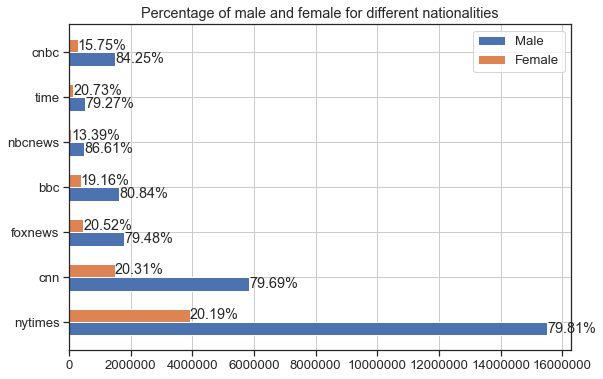

In [22]:
# speaker's nationality
nationality_set = ['United States of America', 'United Kingdom',
               'Australia', 'Canada', 'France', 'Germany', 'India']
male_count = []
female_count = []
gender_percentage = []

for domain in nationality_set:
    print(domain)
    domain_data = data[data['nationality'].apply(lambda x: domain == x)]

    domain_gender_data = domain_data.groupby('gender')
    domain_gender_freq = domain_gender_data.agg({'numOccurrences': 'sum'}).sort_values(by='numOccurrences',
                                                                                       ascending=False)
    male_count.append(domain_gender_freq.loc['male'][0])
    female_count.append(domain_gender_freq.loc['female'][0])

    gender_per = domain_gender_freq.loc['female'] / domain_gender_freq[:2].sum()
    gender_percentage.append(gender_per[0])


fig, ax = plt.subplots(figsize=(9, 6))
ax.get_xaxis().get_major_formatter().set_scientific(False)
# plt.figure()
y=np.arange(len(domains_set))
bar_width=0.3

plt.barh(y, male_count, bar_width, label='Male')
plt.barh(y+bar_width, female_count, bar_width, label='Female')

for a, b1, b2, v in zip(y, male_count, female_count, gender_percentage):
    plt.text(b1, a-0.3*bar_width, '{:.2%}'.format(1-v))
    plt.text(b2, a+0.7*bar_width, '{:.2%}'.format(v)) # , ha='center', va='bottom')

plt.title('Percentage of male and female for different nationalities')
plt.grid(linestyle='-')
plt.legend()
plt.yticks(y+0.5*bar_width, domains_set)
plt.show()

To our surprise, the difference of female percentage among different nationality is not that large, comparing with their Gender Inequality Index. India's Inequality Index (0.488, rank 123) is much higher than other developed countries in the data (e.g. 0.204, rank 46 in the United States and 0.049, rank 8 in France), yet there has been no significant progress or improvement in the percentage of women's voices.

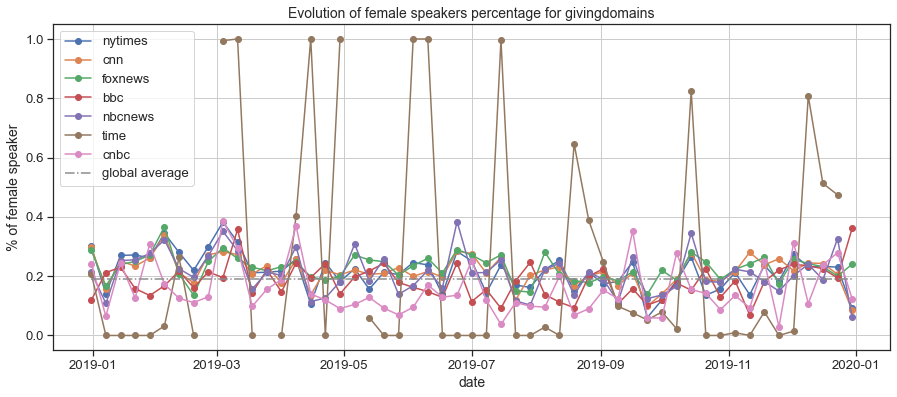

In [23]:
# study the evolution of gender bias for different news domains, speaker's party, and nationality.
def gender_bias_time_series(data, subgroups, fields):
    '''
    Input:
    data: QuoteBank data.
    topics: topics that you are interested at, such as 'COVID', 'health' and so on.
    publisher: Here you can input the names of publishers(i.e. domains), for example, 'cnn',
               'nytimes',.... Then you can get the data from that publisher;
               If you want data from all publishers, you should input 'whole'
    '''
    # features are defined and got before
    fig, ax = plt.subplots(1,1, figsize = (15,6))
    for subgroup in subgroups:
        if fields == 'domains':
            mapped_data = data[data.domains.apply(lambda x: subgroup in x)]
        else:
            mapped_data = data[data[fields] == subgroup]

        # sort by date
        mapped_data = mapped_data.sort_values(by='date')
        # parse to datetime
        mapped_data['date'] = pd.to_datetime(mapped_data['date'], format = ('%Y-%m-%d'))
        mapped_data['date'] = mapped_data['date']-pd.to_timedelta(7, unit='d')

        # male
        male_data = mapped_data[mapped_data.gender == 'male']
        male_occu = male_data.groupby([pd.Grouper(key = 'date', freq='W-MON')]).agg({'numOccurrences':'sum'})
        # female
        feml_date = mapped_data[mapped_data.gender == 'female']
        feml_occu = feml_date.groupby([pd.Grouper(key = 'date', freq='W-MON')]).agg({'numOccurrences':'sum'})

        percentage = feml_occu / (feml_occu + male_occu)
        # print(percentage)
        # percentages.append(percentage)
        plt.plot(percentage, label=subgroup, marker='o')
    gender_data = data.groupby('gender')
    gender_freq = gender_data.agg({'numOccurrences': 'sum'}).sort_values(by='numOccurrences',
                                                                         ascending=False)
    global_average = gender_freq.loc['female'] / (gender_freq.loc['female'] + gender_freq.loc['male'])
    global_average = pd.Series([global_average[0]] * len(percentage), index=percentage.index)
    plt.plot(global_average, label='global average', linestyle='dashdot')
    plt.grid(linestyle='-')
    plt.xlabel('date', fontsize=14)
    plt.ylabel('% of female speaker', fontsize=14)
    plt.legend()
    plt.title("Evolution of female speakers percentage for giving" + fields,
              fontsize=14)

# news outlets
gender_bias_time_series(data, subgroups=domains_set, fields='domains')

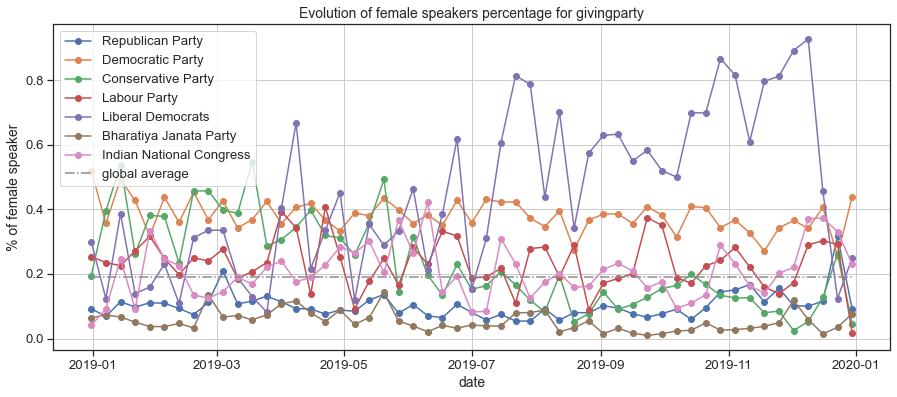

In [24]:
# speaker's party
gender_bias_time_series(data, subgroups=party_set, fields='party')

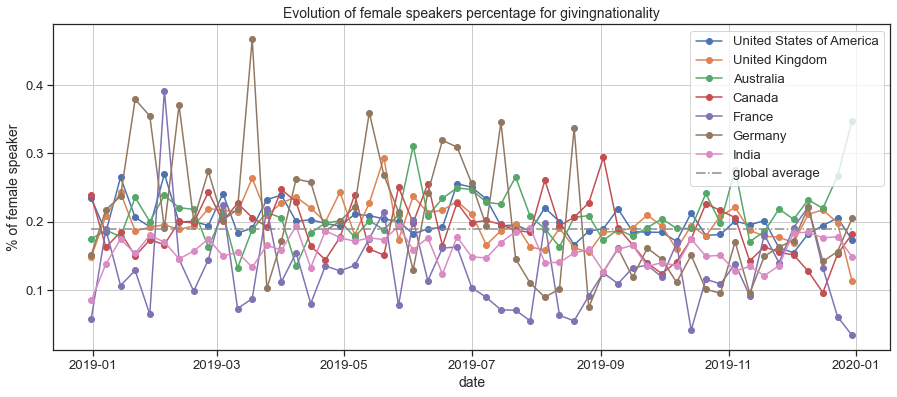

In [25]:
# speaker's nationality
gender_bias_time_series(data, subgroups=nationality_set, fields='nationality')

As for the time change situation, the proportion of women fluctuates more with the hot news and other factors, but overall, there is no significant increase or decrease in the proportion of women quoted.

In conclusion, speakers attributes displayed in different media may have variances to some degree. And media's interest for the specific topics, which reflected from speakers, have much greater variances.

# 3. Do topics reveal potential gender bias? How?
Obviously, the terms used by males and females may have varying levels of exposure under different news topics, therefore looking at the gender ratio of quoted speakers under various topics can help us conduct a more detailed analysis. To extract related quotations from the data, we manually select 9 common news topics and define keywords for each of these topics.

We use the pretrained sentiment classification BERT based model to classify quotations to different sentiments.

In [44]:
# The data are preprocessed by other files, here we just load them and plot them.
data_folder = 'plotly_data'
topic_folder = data_folder + '/topic-sentiment-data'

start, end = 2015, 2020

colors = ['#7fecad', '#4c8dae', '#ffb3a7']
TOPICS = ['gender', 'education', 'health', 'lifestyle', 'entertainment', 'politics', 'people', 'business', 'sports']
TOPICS.reverse()
#
df_topic_num = pd.DataFrame(columns=['Topic', 'Num_Occurrences'])


def get_topic_numOccurrences(df_topic2num=df_topic_num):
    for topic in TOPICS:
        df = pd.read_csv(topic_folder + '/' + topic + '-sentiment.csv')
        Num = df.numOccurrences.sum()
        df_topic2num = df_topic2num.append({'Topic': topic, 'Num_Occurrences': Num}, ignore_index=True)
    return df_topic2num


df_topic_num = get_topic_numOccurrences(df_topic_num)
df_topic_num = df_topic_num.sort_values(by='Num_Occurrences')


#
def preprocess_sentiment_topic(topic):
    df = pd.read_csv(topic_folder + '/' + topic + '-sentiment.csv')
    df_gp = df.groupby(['date', 'gender']).agg({'numOccurrences': 'sum'})
    df_gp_pt = df_gp.groupby(level=0).apply(lambda x: 100 * x / x.sum())
    df_gp_pt = df_gp_pt.rename(columns={'numOccurrences': 'percent'})
    df_gp_pt_reset = df_gp_pt.reset_index()
    df_gp_pt_reset = df_gp_pt_reset[df_gp_pt_reset.gender == 'female']
    df_gp_pt_reset['Topic'] = topic
    return df_gp_pt_reset


all_sentiments_list = []

for topic in TOPICS:
    tmp_df = preprocess_sentiment_topic(topic)
    all_sentiments_list.append(tmp_df)

all_sentiments_df = pd.concat(all_sentiments_list)
all_sentiments_df = all_sentiments_df.rename(columns={'date': 'Date'})
bgc = '#323650'
heatmap_df = pd.crosstab(all_sentiments_df['Topic'], all_sentiments_df['Date'],
                         values=all_sentiments_df.percent, aggfunc='sum'
                         )
heatmap_df = heatmap_df.reindex(TOPICS)
heatmap_fig = px.imshow(heatmap_df, labels=dict(color="Percentage"), zmin=0, zmax=100, color_continuous_scale='RdBu_r',
                        origin='lower', aspect='auto',
                        title='Monthly female percentages for nine topics (average over all outlets)')

heatmap_fig.update_layout(margin=dict(t=60, l=30, r=30, b=40),
                          paper_bgcolor=bgc,
                          yaxis=dict(
                              titlefont_size=16,
                              tickfont_size=14,
                          ),
                          )

heatmap_fig.layout.font.color = '#FFFFFF'
heatmap_fig.show()

We begin by plotting the percentage of women speakers by month for each topic. As seen on the vertical axis of the chart, these themes encompass a wide range of domains typically encountered in the news. As can be seen, news media treat male and female voices differently depending on the subject.

For women, quotes related to **education**, **health**, **lifestyle** and **entertainment** are more prevalent than the average level. Whereas in **politics**, **people**, **business** and **sports**, women percentages are below the global average as shown in the first graph above. To our surprise, under the topic of gender, the percentage of women speaking out is at its highest level, but their voices are just almost equal to men's (still less).

To summarize briefly, sources of female quotes are more often in **caregiver** roles and male quotes are more in **sports** and **business** roles, reflecting the position of women as **caregivers** but men as **“sports mania”** and **breadwinners**.

In addition, we look at the sentiments of the statements in three ways (**Positive**, **Negative**, and **Neutral**) to see how they differ between men and women on various issues. Due to the limited space, we only plot two topics in this notebook, similar observation can be found in other topics.

In [47]:
def plot_sentiment(topic):
    colors = ['#7bcfa6', '#4c8dae', '#c32136']

    fig = go.Figure()
    fig.update_layout(
        template="plotly",
        barmode="stack",
        plot_bgcolor='#fcefe8'
    )
    df = pd.read_csv(topic_folder + '/' + topic + '-sentiment.csv')
    df_gp = df.groupby(['topic', 'gender', 'sentiment']).agg({'numOccurrences': 'sum'})
    df_gp_percent = df_gp.groupby(level=[0, 1]).apply(lambda x: 100 * x / x.sum()).reset_index()
    df_gp_occur = df_gp.groupby(level=[0, 1]).apply(lambda x: x).reset_index()

    for r, c in zip(df_gp_percent.sentiment.unique(), colors):
        plot_df = df_gp_percent[df_gp_percent.sentiment == r]
        fig.add_trace(
            go.Bar(x=[plot_df.topic, plot_df.gender],
                   y=plot_df.numOccurrences.round(2), name=r, marker_color=c,
                   # visible=False,
                   hovertemplate='<b>%{label}: </b>%{y}%</br>'
                   ),
        )
        fig.update_layout(
            title='Three sentiments distribution between Male and Female in {} topic'.format(topic),
            xaxis=dict(
                titlefont_size=16,
                tickfont_size=14,
            ),
            yaxis=dict(
                title='Sentiment Percentage',
                titlefont_size=16,
                tickfont_size=14,
            ),
        )

    return fig
topic = 'gender'
plot_sentiment(topic)

Let’s first look at gender. You can notice that for certain painful topics, such as **"abortion"** and **"sexual harassment"**, men and women tend to express a negative feeling. This may mean that these social problems have not been significantly improved or resolved in society.

In [48]:
topic = 'sports'
plot_sentiment(topic)

The most popular keyword in sports for males is **“football”**, extremely larger than others, especially for **“swimming”**, which is consistent with our normal perceptions. When we talk about football games, the first image should be that of male athletes running on the court. For women, they prefer “tennis” more(even greater than such a common and popular topic, **“football”**). Put another way, football is more **"masculine"** than tennis.

# 4. Detecting the linguistic differences between men and women in the quotation.

We already know that men and women tend to display different preferences towards different subjects (from heat map and sentiment analysis). Now we ask ourselves: can we predict gender (i.e. male or female) when we know the quotations?

If the quotation style discrepancy between males and females is not as significant as we expected. then the model we developed would be equivalent to a random assumption (we cannot infer gender from what they say), i.e. 50%. But if the model works better than 50%. it indicates that there is indeed some bias in quotes made by different genders, which is therefore identified by the model as a discriminatory feature.


In [29]:
# define the tokenizer
stemmer = SnowballStemmer("english", ignore_stopwords=True)
def tokenize(text):
    text = "".join([ch for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    return " ".join([stemmer.stem(word.lower()) for word in tokens])

In [32]:
path = "E:\\PycharmProject\\ada_project\\data\\"

years = [2015, 2016, 2017, 2018, 2019, 2020]
n_sample = 100000
all_data = []
all_labels = []

# sample the quotation for each year
for year in years:
    df = pd.read_csv(path + 'processed-quotes-{}.csv'.format(year))
    female_data = df[df.gender == 'female'].sample(n=n_sample, replace=False, random_state=42)
    male_data = df[df.gender == 'male'].sample(n=n_sample, replace=False, random_state=42)
    sample_data = pd.concat([female_data['quotation'], male_data['quotation']])

    # generate labels
    female_label, male_label = np.zeros(n_sample), np.ones(n_sample)
    all_labels.append(np.concatenate((female_label, male_label), axis = 0))

    all_data.append(sample_data)
train_quotations = pd.concat(all_data)  # data
all_labels = np.concatenate(all_labels, axis = 0)  # labels

In [33]:
# Get the common words from quotations in female

vocabulary_size = 2000

common_words = {}
stop_words = stopwords.words('english')
all_q_list = train_quotations.values
for quotation in tqdm(train_quotations):
    cur_quo = tokenize(quotation)
    for word in cur_quo.split():
        if word not in stop_words:
            if word in common_words:
                common_words[word]+=1
            else:
                common_words[word]=1
sort_common_words = sorted(common_words.items(),key=lambda x: -x[1])

vocabulary_all = sort_common_words[:vocabulary_size].copy()
vocabulary_all = dict(vocabulary_all)
vocabulary_all = sorted(vocabulary_all.items(), key = lambda x: -x[1])
vocabulary_index = {}
index_vocabulary = {}
for i in range(vocabulary_size):
    vocabulary_index[vocabulary_all[i][0]]=i
    index_vocabulary[i] = vocabulary_all[i][0]

vectorizer = TfidfVectorizer(vocabulary=vocabulary_index)
all_matrix = vectorizer.fit_transform(all_q_list)
all_matrix.shape

  0%|          | 0/1200000 [00:00<?, ?it/s]

(1200000, 2000)

In [34]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(all_matrix, all_labels)
model.score(all_matrix, all_labels)

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.5976333333333333

As we can see, R-Square is 59.76%. As discussed above, this model does have some capacity for interpretation. Let us look at these most predictable words and see what we get.

In [35]:
# show men's top 50 most predictive words.
topk = 50
coef = model.coef_[0]
index = sorted(range(len(coef)),key = lambda x: coef[x], reverse = True)
word_scores = {}
for step, i in enumerate(index):
    word_scores[index_vocabulary[i]] = coef[i]

word_scores = pd.Series(word_scores)
men_topk_word = word_scores.head(topk)
men_topk_word

quarterback     5.209829
playoff         3.120811
pitch           2.450593
player          2.361112
guy             2.284070
game            2.269179
coach           2.072887
club            2.056337
ball            2.019665
squad           2.003911
bowl            1.953527
draft           1.685586
score           1.585964
cricket         1.500138
championship    1.441055
command         1.424455
stadium         1.420364
bat             1.402131
play            1.390415
digit           1.387313
team            1.369067
modi            1.346839
hockey          1.289452
bjp             1.267076
premier         1.193389
field           1.180151
swing           1.146732
wife            1.132491
speed           1.126933
veteran         1.096812
camp            1.078245
investor        1.055328
accord          1.045482
quarter         1.040166
win             1.033743
saturday        1.029790
zone            1.002330
season          0.977308
market          0.939676
knock           0.936756


In [37]:
# show women's top 50 most predictive words.
women_topk_word = word_scores.tail(topk).sort_values(ascending=True)
women_topk_word

women        -3.798059
husband      -3.034445
woman        -2.863080
girl         -2.778915
dress        -2.735883
pregnant     -2.572899
makeup       -2.385651
gender       -2.061600
hair         -2.020711
mom          -1.977197
sister       -1.867104
mum          -1.732473
daughter     -1.678754
rape         -1.640777
medal        -1.636659
birthday     -1.587880
skin         -1.492489
queen        -1.487909
fashion      -1.476451
male         -1.447740
sex          -1.421431
sweet        -1.419185
mother       -1.411114
oh           -1.344928
wear         -1.322255
children     -1.311335
love         -1.303396
sexual       -1.247343
color        -1.236183
child        -1.229826
sic          -1.223136
birth        -1.214103
confer       -1.181359
sing         -1.179756
parent       -1.168140
photo        -1.161282
cant         -1.132031
angel        -1.126691
dinner       -1.085243
intern       -1.075974
dont         -1.045550
nervous      -0.991081
didnt        -0.983361
juli       

In [40]:
data_folder = 'E:\JupyterNotebook\Ada\Project\m3\word_scores.csv'
word_scores = pd.read_csv(data_folder, header=0)
word_scores

,word,score
0,quarterback,5.840626
1,playoff,3.273132
2,pitch,2.529542
3,player,2.496365
4,guy,2.432545
...,...,...
1995,pregnant,-2.509088
1996,girl,-2.826770
1997,woman,-2.912545
1998,husband,-2.970391


In [41]:
def plot_word_could(word_frequencies, weights, file_name):
    wc = WordCloud(max_font_size=80, background_color="black", width=1000, height=860)
    wc.generate_from_frequencies(word_frequencies)

    word_list = []
    freq_list = []
    fontsize_list = []
    position_list = []
    orientation_list = []
    color_list = []

    for (word, freq), fontsize, position, orientation, color in wc.layout_:
        word_list.append(word)
        freq_list.append(freq)
        fontsize_list.append(fontsize)
        position_list.append(position)
        orientation_list.append(orientation)
        color_list.append(color)

    # get the positions
    x = []
    y = []
    for i in position_list:
        x.append(i[0])
        y.append(i[1])

    # get the relative occurence frequencies
    new_freq_list = []
    for i in freq_list:
        new_freq_list.append(i * 100)

    colors = [px.colors.qualitative.Prism[random.randrange(1, 10)] for i in range(topk)]

    trace = go.Scatter(

        x=np.array(x) + 5,
        y=np.array(y) + 5,
        textfont=dict(size=new_freq_list,
                      color=colors),
        hoverinfo='text',
        hovertext=['{0}: {1}'.format(w, f) for w, f in zip(word_list, weights)],
        mode="text",
        text=word_list,
    )

    layout = go.Layout(autosize=True,
                       xaxis=dict(showgrid=False,
                                  showticklabels=False,
                                  zeroline=False,
                                  automargin=True),
                       yaxis=dict(showgrid=False,
                                  showticklabels=False,
                                  zeroline=False,
                                  automargin=True),
                       margin=go.layout.Margin(pad=1000),
                       )


    fig = go.Figure(data=[trace], layout=layout)
    fig.update_layout(margin=dict(t=10, l=10, r=10, b=10))
    fig.write_html(file_name, auto_open=False)
    # fig.show()
    return fig

In [43]:
topk = 50
male_topk_words = word_scores.head(topk).set_index('word')['score']
weights = male_topk_words.values
topk_words_freq = male_topk_words.apply(lambda x: int(x * 10))
word_frequencies = topk_words_freq.to_dict()
word_frequencies['quarterback'] = 42

fig = plot_word_could(word_frequencies, weights=weights, file_name='male_word_cloud.html')
fig.show()

In [42]:
female_topk_words = word_scores.tail(topk).set_index('word')['score']
female_topk_words = female_topk_words.apply(abs).sort_values(ascending=False)
weights = female_topk_words.values
topk_words_freq = female_topk_words.apply(lambda x: int(x * 10))
word_frequencies = topk_words_freq.to_dict()
fig = plot_word_could(word_frequencies, weights=weights, file_name='female_word_cloud.html')
fig.show()

Word clouds shows the top 50 most predictable words for males and females respectively, where we can see that the representative words for male quotes are dominated by sports and business-related words, which is in line with our previous finds in Heatmap. Therefore, it confirms our observation: men are indeed more "ambitious" and "active".

For women, these are more their own characteristics and life-like words, which is also consistent with our earlier analysis.